# Fast front-prop

Fast front-prop implementation on matrices (see original `front-prop` idea in original notebook).
This one is ~100x faster, by parallelising all neurons in the layer.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm

import importlib

from fp_utils import sphere_rnd_gen, shanon_entropy_binned, plot_matrix
from fp_datasets import SimplePatterns

/tmp/ipykernel_4478/1786315376.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the CPU


In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


## Learn simple patterns

In [59]:

def single_layer_frontprop_run(in_size, out_size, iterations, patterns_probs, pattern_noise, device, report_count=5):
    
    report_interval = 0 if report_count == 0 else int(iterations / report_count)

    layer = fp.FpLinear(in_size, out_size, device=device)

    if report_interval > 0:
        print("\n----------------\nRunning frontprop on following patterns:")
        plot_matrix(dims, *SimplePatterns.get_all_patterns())
        print(f"with probabilities:\n{patterns_probs}\n\n")

    for i in range(iterations):

        input = SimplePatterns.get_simple_pattern(patterns_probs, noise=pattern_noise) \
            .to(device).flatten().unsqueeze(0)

        out = layer.forward(input)

        if report_interval > 0 and i % report_interval == 0:
            print(f"\n --- Iter #{i} --- ")
            plot_matrix(dims, *([layer.weight[i] for i in range(neurons)]))
            # print("Layer outputs:")
            # print(out)
            # print("for input")
            # plot_matrix(DIMS, input)

    return layer




----------------
Running frontprop on following patterns:


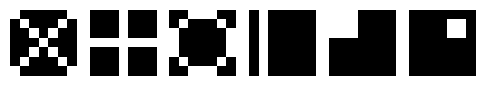

with probabilities:
[0.17 0.17 0.17 0.17 0.17 0.17]



 --- Iter #0 --- 


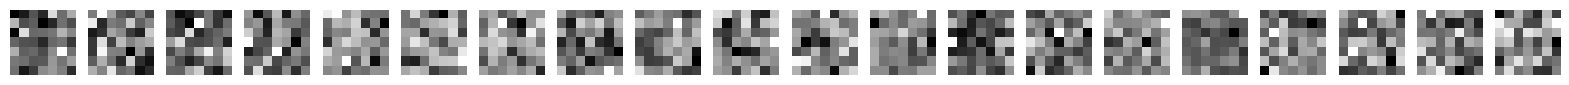


 --- Iter #4000 --- 


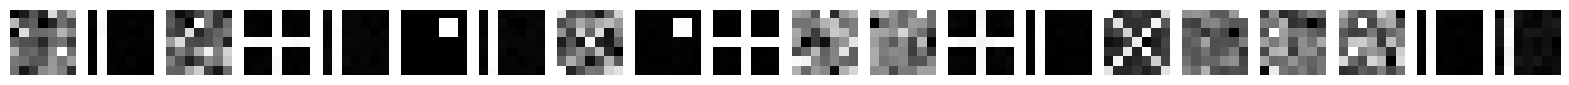


 --- Iter #8000 --- 


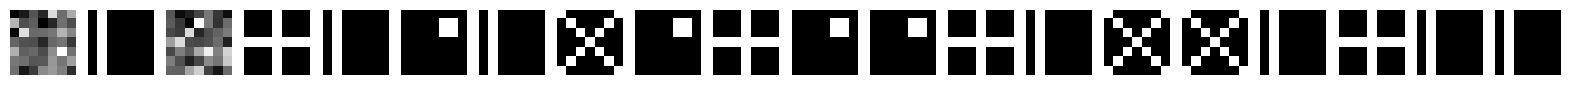


 --- Iter #12000 --- 


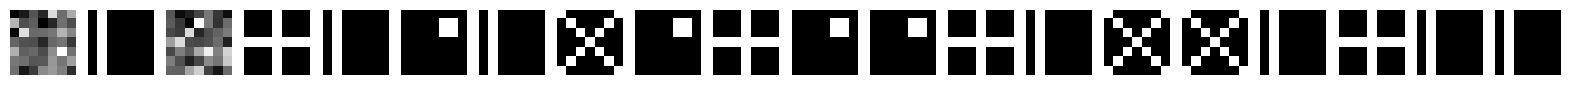


 --- Iter #16000 --- 


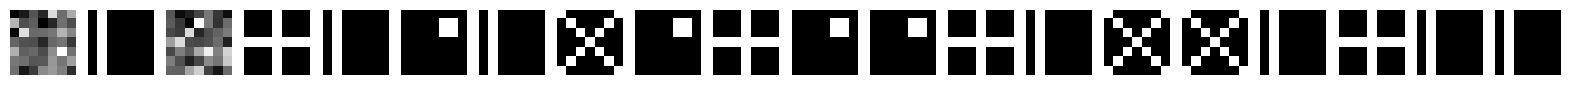

In [60]:
import torch_module as fp

dims = SimplePatterns.get_pattern_dims()
iters = 20000  # 50000
neurons = 20

noise_rate = 0.0
pattern_probs = [1.0] * SimplePatterns.get_all_patterns_count()
# pattern_probs = [10,1,1,1,1,1]
pattern_probs /= np.sum(pattern_probs)

# train the layer
layer = single_layer_frontprop_run(dims[0] * dims[1],
                                   neurons,
                                   iters,
                                   pattern_probs,
                                   noise_rate,
                                   device, report_count=5)



In [22]:

def count_active_per_pattern(layer, device):
    activations_per_pattern = []
    for p in SimplePatterns.get_all_patterns(len(pattern_probs)):
        input = p.to(device).flatten().unsqueeze(0)
        out = layer.forward(input)

        # count active neurons
        active_count = torch.count_nonzero(out)
        activations_per_pattern.append(active_count)
    return activations_per_pattern


In [34]:
# run N training runs to see if there's no preference towards any specific pattern

TRAIN_RUNS = 100  # FIXME 100

active_per_pattern_agg = []

for i in tqdm(range(TRAIN_RUNS)):
    layer = single_layer_frontprop_run(dims[0] * dims[1], neurons, iters, pattern_probs, noise_rate, device, report_count=0)
    active_per_pattern_agg.append(count_active_per_pattern(layer, device))

active_per_pattern_agg = np.array(active_per_pattern_agg)

assert active_per_pattern_agg.shape == (TRAIN_RUNS, SimplePatterns.get_all_patterns_count())



  0%|          | 0/100 [00:00<?, ?it/s]

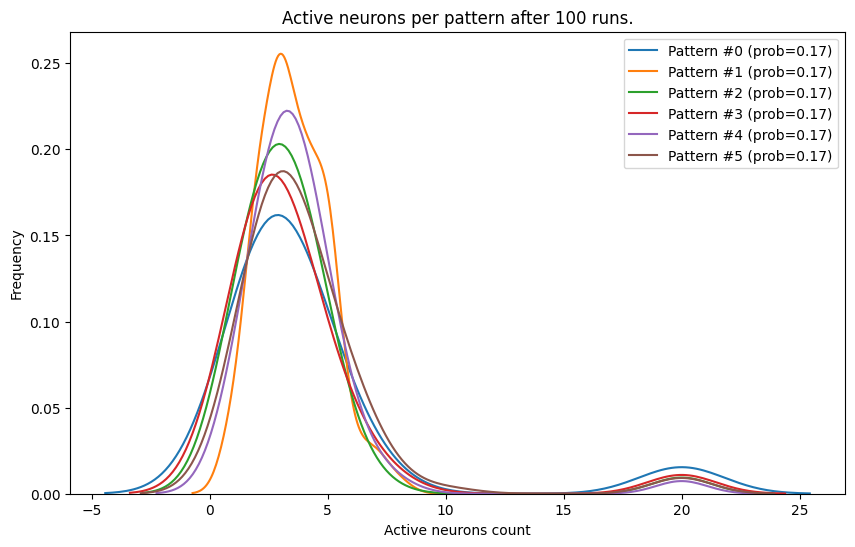

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

plt.figure(figsize=(10, 6))

for i in range(SimplePatterns.get_all_patterns_count()):
    # plt.hist(active_per_pattern_agg[:, i], bins=NEURONS, histtype='step', linewidth=2, label=f'Pattern #{i}')
    # sns.histplot(active_per_pattern_agg[:, i], bins=NEURONS, linewidth=2, label=f'Pattern #{i}', kde=True)
    sns.kdeplot(active_per_pattern_agg[:, i], label=f'Pattern #{i} (prob={round(pattern_probs[i], 2)})')

plt.xlabel('Active neurons count')
plt.ylabel('Frequency')
plt.title(f'Active neurons per pattern after {TRAIN_RUNS} runs.')
plt.legend()
plt.show()

Patterns: #0 to #5


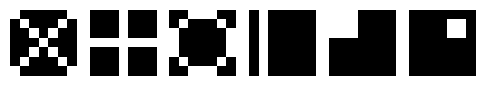

In [47]:
print("Patterns: #0 to #5")
plot_matrix(dims, *SimplePatterns.get_all_patterns(len(pattern_probs)))

In [52]:
print("Active neurons per pattern:")
print("          #0   #1   #2   #3   #4   #5")
print("Mean:\t",    np.mean(active_per_pattern_agg, axis=0))
print("Std:\t",     np.std(active_per_pattern_agg, axis=0))
print("Median:\t",  np.median(active_per_pattern_agg, axis=0))

Active neurons per pattern:
          #0   #1   #2   #3   #4   #5
Mean:	 [4.28 3.56 3.54 3.70 3.76 4.05]
Std:	 [4.53 1.44 3.19 3.66 2.72 3.27]
Median:	 [3.00 3.00 3.00 3.00 3.00 3.00]


### Conclusion
Neither noise or uneven probabilities prevent the network from learning all patterns. 

Even with pattern likelihood imbalance of 10:1, the network still learns to activate all patterns.
Number of active neurons per pattern varies, but, notably, does not depend on pattern probability, or the number of ones/zeros in the pattern.

Noise does not affect convergence, but larger amount of noise do slow down learning (as expected).

TODO: plot those two effects (activation imbalance vs pattern probs imbalance; noise vs learning speed)
